In [ ]:

import kagglehub
dheerajperumandla_drowsiness_dataset_path = kagglehub.dataset_download('dheerajperumandla/drowsiness-dataset')

print('Data source import complete.')


100%|██████████| 161M/161M [00:01<00:00, 85.1MB/s]

Extracting files...


Data source import complete.


# Driver Drownsiness Detection

## import Denpendencies

In [2]:
!pip install opencv-python
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML

# Set Constant

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 255
CHANNELS = 3

# Load Dataset

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/train',
    seed = 123,
    shuffle = True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

Found 2900 files belonging to 4 classes.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
class_names = dataset.class_names
class_names

['Closed', 'Open', 'no_yawn', 'yawn']

# Visaulize some image

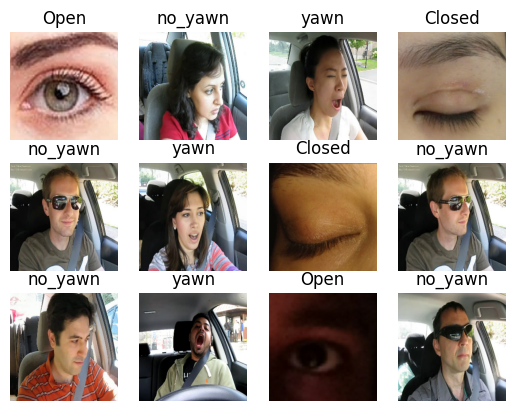

In [7]:
for image_batch, labels_name in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_name[i]])
        plt.axis('off')

plt.show()

# Split Dataset

In [11]:
def get_split_data(ds, train_split=0.8, test_splt=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split + test_splt + val_split ) == 1
    ds_size= len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)

        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)

        return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_split_data(dataset)

In [13]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

72
10
9


# Cache, Shuffle and Prefitch data

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Resizing And Normalization

In [15]:
import tensorflow as tf
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Removed 'experimental.preprocessing.'
    layers.Rescaling(1.0 / 255) # Removed 'experimental.preprocessing.'
])

# Data Augmentation

In [16]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Removed 'experimental.preprocessing.'
    layers.RandomRotation(0.2)  # Removed 'experimental.preprocessing.'
])

# Applying Data Augmentation to Train Dataset

In [17]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Mode Architecture

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [20]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 255, 255, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 253, 253, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 126, 126, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 124, 124, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 128)        

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=100,
    callbacks=[callback, early_stopping]
)

Epoch 1/100
72/72 [==============================] - 40s 547ms/step - loss: 0.3944 - accuracy: 0.7866 - val_loss: 0.4389 - val_accuracy: 0.7222
Epoch 2/100
72/72 [==============================] - 39s 545ms/step - loss: 0.3948 - accuracy: 0.7888 - val_loss: 0.3529 - val_accuracy: 0.8056
Epoch 3/100
72/72 [==============================] - 39s 542ms/step - loss: 0.3915 - accuracy: 0.8002 - val_loss: 0.3256 - val_accuracy: 0.8125
Epoch 4/100
72/72 [==============================] - 39s 542ms/step - loss: 0.3712 - accuracy: 0.8037 - val_loss: 0.3470 - val_accuracy: 0.8125
Epoch 5/100
72/72 [==============================] - 39s 545ms/step - loss: 0.3661 - accuracy: 0.8124 - val_loss: 0.3198 - val_accuracy: 0.8472
Epoch 6/100
72/72 [==============================] - 39s 544ms/step - loss: 0.3304 - accuracy: 0.8403 - val_loss: 0.2536 - val_accuracy: 0.8750
Epoch 7/100
72/72 [==============================] - 40s 552ms/step - loss: 0.3394 - accuracy: 0.8490 - val_loss: 0.3731 - val_accuracy:

Text(0.5, 1.0, 'Training and Validation loss')

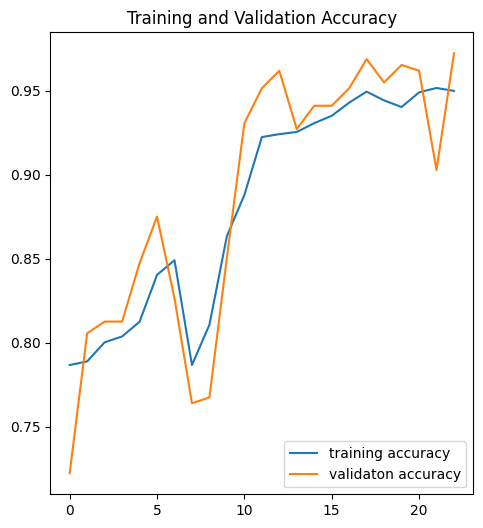

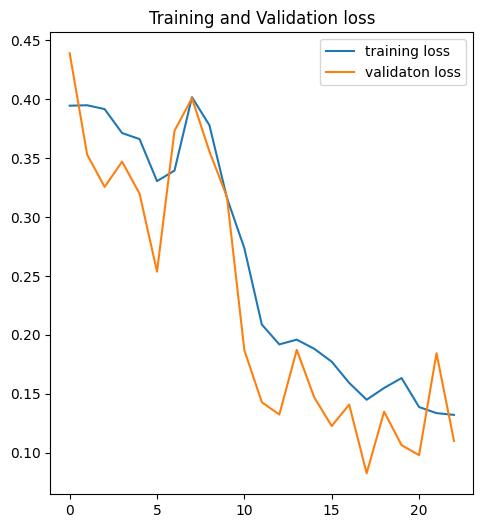

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss =history.history['loss']
val_loss = history.history['val_loss']

EPOCHS = len(acc)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'training accuracy')
plt.plot(range(EPOCHS), val_acc, label='validaton accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label = 'training loss')
plt.plot(range(EPOCHS), val_loss, label='validaton loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

# System To Make Predict

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidance = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidance

1/1 [==============================] - 0s 32ms/step


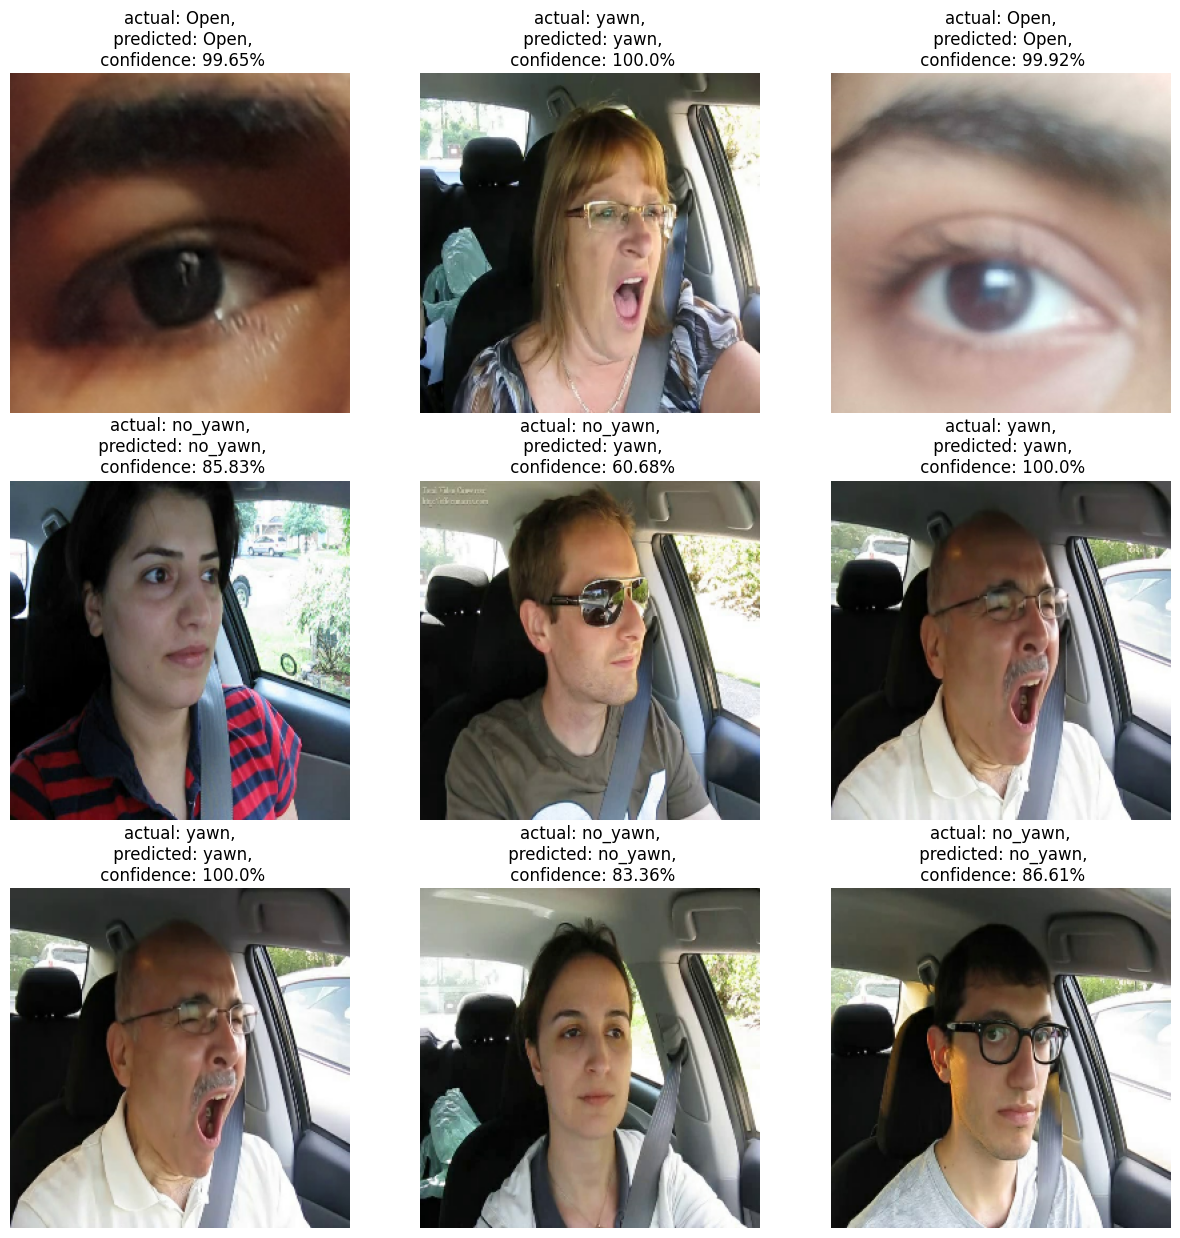

In [27]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"actual: {actual_class},\n predicted: {predicted_class},\n confidence: {confidence}%")
        plt.axis('off')


In [28]:
model.save('model.keras')